# 1.0 - Initial data exploration


In [1]:
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray as riox

%load_ext autoreload
%autoreload 2

## GBIF


### Data unpacking


Copy the raw GBIF data from the EO data registry and unzip.

```bash
# Performed from root project directory

# Copy raw data
cp -r ../eo-data/data/raw/gbif/all_tracheophyta_non-cult_2024-01-21.* data/raw/gbif/
cp -r ../eo-data/data/raw/masks/forest_type_2018 data/raw/masks/
cp ../eo-data/data/raw/masks/germany.geojson data/raw/masks/

# Unzip
unzip -q data/raw/gbif/all_tracheophyta_non-cult_2024-01-21.zip -d data/raw/gbif/
unzip -q data/raw/masks/forest_type_2018/forest_type_2018_germany_10m.zip -d data/raw/masks/forest_type_2018/
unzip -q data/raw/masks/forest_type_2018/Results/EEA.zip -d data/raw/masks/forest_type_2018/
unzip -q data/raw/masks/forest_type_2018/FTY_2018_010m_de_03035_v010.zip -d data/raw/masks/forest_type_2018/

# Rename
mv data/raw/gbif/occurrence.parquet data/raw/gbif/all_tracheophyta_non-cult_2024-01-21.parquet

# Remove unzip-cruft
rm data/raw/gbif/all_tracheophyta_non-cult_2024-01-21.zip
rm data/raw/masks/forest_type_2018/forest_type_2018_germany_10m.zip
rm data/raw/masks/forest_type_2018/FTY_2018_010m_de_03035_v010.zip
rm -rf data/raw/masks/forest_type_2018/Results
```


### Exploration


#### Vascular plant occurrences


First look at a single chunk to get the relevant column names and their data types.


In [2]:
df_fn = Path("../data/raw/gbif/all_tracheophyta_non-cult_2024-01-21.parquet")

In [3]:
pd.read_parquet(df_fn / "000000", engine="pyarrow").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307276 entries, 0 to 307275
Data columns (total 50 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   gbifid                            307276 non-null  object        
 1   datasetkey                        307276 non-null  object        
 2   occurrenceid                      307274 non-null  object        
 3   kingdom                           307276 non-null  object        
 4   phylum                            307276 non-null  object        
 5   class                             307275 non-null  object        
 6   order                             306579 non-null  object        
 7   family                            306510 non-null  object        
 8   genus                             303103 non-null  object        
 9   species                           294751 non-null  object        
 10  infraspecificepithet            

Looks like the columns we need to care about are `species`, `decimallatitude`, and `decimallongitude` (`issue` shouldn't be of importance since the initial query predicate already grabs only occurrences with valid coordinates).


## Germany mask

#### Germany mask


<Axes: >

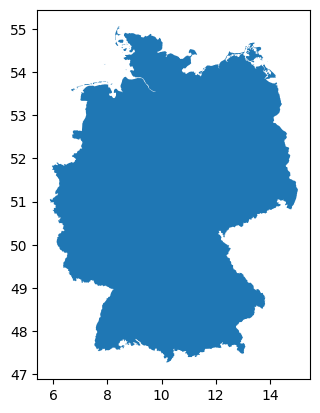

In [4]:
de_mask_fn = Path("../data/raw/masks/germany.geojson")
de_mask = gpd.read_file(de_mask_fn).to_crs("EPSG:4326")
de_mask.plot()

## Forest mask

Look at one tif as a sample.

In [5]:
f_mask_fns = Path("../data/raw/masks/forest_type_2018/FTY_2018_010m_de_03035_v010/DATA").glob("*.tif")
f_mask = riox.open_rasterio(list(f_mask_fns)[0])
f_mask

<xarray.DataArray (band: 1, y: 10000, x: 10000)>
[100000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4e+06 4e+06 4e+06 4e+06 ... 4.1e+06 4.1e+06 4.1e+06
  * y            (y) float64 2.9e+06 2.9e+06 2.9e+06 ... 2.8e+06 2.8e+06 2.8e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    DataType:            Thematic
    RepresentationType:  THEMATIC
    _FillValue:          240
    scale_factor:        1.0
    add_offset:          0.0

Get the CRS and resolution:

In [6]:
print("CRS:", f_mask.rio.crs)
print("Resolution:", f_mask.rio.resolution())

CRS: PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]
Resolution: (10.0, -10.0)


And the unique values (should be 0 = non-forested, 1 = broadleaf trees, 2 = coniferous trees, 240+ = nodata).

In [7]:
np.unique(f_mask.values)

array([0, 1, 2], dtype=uint8)

## Destination grids (Sentinel-2)

In [8]:
s2_10m_fn = Path("../data/raw/sentinel-2/fca_grid_empty_raster_R10m.tif")
s2_20m_fn = Path("../data/raw/sentinel-2/fca_grid_empty_raster_R20m.tif")

s2_10m = riox.open_rasterio(s2_10m_fn)
s2_20m = riox.open_rasterio(s2_20m_fn)

In [9]:
print("S2 10m CRS:", s2_10m.rio.crs)
print("S2 10m Resolution:", s2_10m.rio.resolution())
print("\nS2 20m CRS:", s2_20m.rio.crs)
print("S2 20m Resolution:", s2_20m.rio.resolution())

S2 10m CRS: EPSG:32632
S2 10m Resolution: (10.0, -10.0)

S2 20m CRS: EPSG:32632
S2 20m Resolution: (20.0, -20.0)
